# Wyvern Tutorial
## Converting Top-of-Atmosphere Radiance Data to Top-of-Atmosphere Reflectance

## Introduction

Wyvern Dragonette hyperspectral data is delivered as Level-1B (basic) processing level. This is delivered with the pixel representing at-sensor (top-of-atmosphere) radiance units of $ W / (m^2 \cdot sr \cdot um) $.

Before using the data for analysis, the pixel units should be converted to surface reflectance units. The first step in this process is to convert to top-of-atmosphere (TOA) reflectance. This tutorial will show how to convert Wyvern Dragonette Level-1B data to top-of-atmosphere (TOA) reflectance in Python using the supplied metadata.

## Getting Started
- Ensure you have installed Anaconda/Conda
- Build the environment for this notebook using the following command: `conda env create -f environment.yml`
- Run this notebook in your tool of choice (Jupyter Lab, Visual Studio Code, etc), making sure you run it with the conda environment (`wyvern_toa_env`) you just created!

### Import Libraries

In [10]:
import math
import json
import rasterio
import requests

import numpy as np
import matplotlib.pyplot as plt
import earthpy.plot as ep

from pystac import Item
from pystac.extensions.eo import EOExtension
from dateutil import parser

In [2]:
# Change this to False if you have already downloaded the data!
DOWNLOAD_FROM_OPEN_DATA_PROGRAM = True

### Getting Dragonette Data

If you don't have Wyvern data, the dataset used for this tutorial can be downloaded from [Wyvern's Open Data Program](https://opendata.wyvern.space/#/industry/peace_&_security/wyvern_dragonette-001_20240808T073501_51b92993/wyvern_dragonette-001_20240808T073501_51b92993.json).

This next cell will download the Open Data Program dataset. If data from from the Open Data Program is to be downloaded, set `download_from_open_data_program` to True.

In [3]:
# Load STAC item from the Open Data Program
print("Loading STAC Item!")
stac_item_response = requests.get("https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/industry/peace_&_security/wyvern_dragonette-001_20240808T073501_51b92993/wyvern_dragonette-001_20240808T073501_51b92993.json")
stac_item_response.raise_for_status()  # Will raise an error if we have any issues getting the STAC item
stac_item = stac_item_response.json()
print(f"Successfully loaded STAC Item!\nSTAC Item ID: {stac_item['id']}")

# Write STAC metadat to file
local_stac_name = stac_item['id'] + ".json"

# Write GeoTIFF to file
download_url = stac_item['assets']['Cloud optimized GeoTiff']['href']
local_file_name = download_url.split("/")[-1]

if DOWNLOAD_FROM_OPEN_DATA_PROGRAM:
    print(f"Saving STAC metadata to local file named: {local_stac_name}")
    with open(local_stac_name, 'w') as f:
        f.write(json.dumps(stac_item, indent=2))

    print(
        f"Downloading GeoTIFF from STAC Metadata!\nDownload url: {download_url}]\n"
        f"Downloading to local file named: {local_file_name}"    
    )
    with requests.get(download_url, stream=True) as r:
        r.raise_for_status()
        with open(local_file_name, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    print("Download completed!")

Loading STAC Item!
Successfully loaded STAC Item!
STAC Item ID: wyvern_dragonette-001_20240808T073501_51b92993
Saving STAC metadata to local file named: wyvern_dragonette-001_20240808T073501_51b92993.json
Download url: https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-001_20240808T073501_51b92993/wyvern_dragonette-001_20240808T073501_51b92993.tiff]
Download completed!


### Load Dragonette Data

First, load the Cloud-Optimized GeoTIFF and STAC metadata and read the relevant GeoTIFF metadata tags. Replace the filepath and filenames with the relevant Wyvern files that are to be processed.

In [4]:
# Open the Dragonette image
with rasterio.open(local_file_name) as src:
    image_toa_radiance = src.read()
    nodata_value = src.nodata

Dragonette data may come with pixels set as nodata values. We will get the null value from the GeoTIFF and set the numpy array to the numpy nan values. This will ensure these pixels get ignored in any calculations or plotting.

In [5]:
image_toa_radiance[image_toa_radiance == nodata_value] = np.nan

Next open the STAC catalog.json file. This file provides link references to all the files in the delivery. Using PySTAC, the JSON metadata values can be read.

In [6]:
# Open the STAC item metadata
item = Item.from_file(local_stac_name)

The electro-optical extension bands object contains information about the image bands, such as center wavelength and solar illumination. These will later be used to calculate the reflectance values.

In [7]:
# Access the metadata fields in the Electro-Optical STAC extension
dragonette_hsi_asset = item.assets["Cloud optimized GeoTiff"]
bands = EOExtension.ext(dragonette_hsi_asset).bands

## Calculate Top-of-Atmosphere Reflectance

Now that the files and metadata are loaded, the top-of-atmosphere pixel values can be calculated.

### Top-of-Atmosphere Reflectance Formula

The formula for converting top-of-atmosphere radiance to top-of-atmosphere reflectance is

$$ \rho_\lambda = \frac{\pi L _\lambda d^2}{solar\_illumination_\lambda * sin(\theta_{sun})}$$

where

* $L _\lambda$ = the top-of-atmosphere radiance for band $\lambda$
* $d$ = the earth-sun distance on the day of image collection
* $solar\_illumination_\lambda$ = the solar irradiance for band $\lambda$
* $\theta_{sun}$ = the sun elevation in degrees

### Sun-Earth Distance Formula

The sun-earth distance can be calculated using Wyvern metadata with  the following equation.

$$d _{sun\_earth} = 1- (0.01672 * cos(0.9856 * day - 4)) $$

where

$day$ = the count of days from January 1

### Calculate Sun-Earth Distance and Load Metadata Values

First, calculate the day of year from the collection datetime in the STAC metadata.

In [11]:
collection_datetime = parser.parse(item.properties["datetime"])
collection_day_of_year = int(collection_datetime.strftime("%j"))

Next, calculate the sun-earth distance.

In [12]:
sun_earth_distance = 1 - (0.01672 * np.cos(np.deg2rad(0.9856 * (collection_day_of_year - 4))))

The sun elevation angle can be found in the STAC metadata.

In [13]:
sun_elevation = item.properties["view:sun_elevation"]

### Calculate Top-of-Atmosphere Reflectance

Now that the metadata values have been loaded and used to calculate variables, the top-of-atmosphere reflectance values can be calculated for each pixel and each band in the Dragonette image.

In [14]:
# Convert the pixels in all bands to top-of-atmosphere reflectance
image_toa_reflectance = np.empty(image_toa_radiance.shape, dtype=np.float32)

for i in range(len(bands)):
    image_toa_reflectance[i, :, :] = (
        image_toa_radiance[i, :, :] * np.pi * (sun_earth_distance**2)
        ) / (bands[i].solar_illumination * np.sin(np.deg2rad(sun_elevation)))

## Comparing the Top-of-Atmosphere Reflectance Values to Top-of-Atmosphere Radiance

Now that the top-of-atmosphere reflectance values have been calculated, they can be compared to the radiance values.

#### Color-Infrared RGB Image

First, color-infrared RGB images can be created showing the difference in values.

In [15]:
%%capture --no-display
# Plot color infrared RGB images
red_plot_band = 22
green_plot_band = 11
blue_plot_band = 4

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ep.plot_rgb(
    image_toa_radiance,
    rgb=(red_plot_band, green_plot_band, blue_plot_band),
    ax = ax[0],
    str_clip = 0.5,
    stretch = True,
    title="Color Infrared Top-of-Atmosphere Radiance"    
)

ep.plot_rgb(
    image_toa_reflectance,
    rgb=(red_plot_band, green_plot_band, blue_plot_band),
    ax = ax[1],
    str_clip = 0.5,
    stretch = True,
    title="Color Infrared Top-of-Atmosphere Reflectance"    
)

plt.tight_layout()
plt.show()

: 

### Pixel Value Histograms

The histograms of the color-infrared bands can also be plotted.

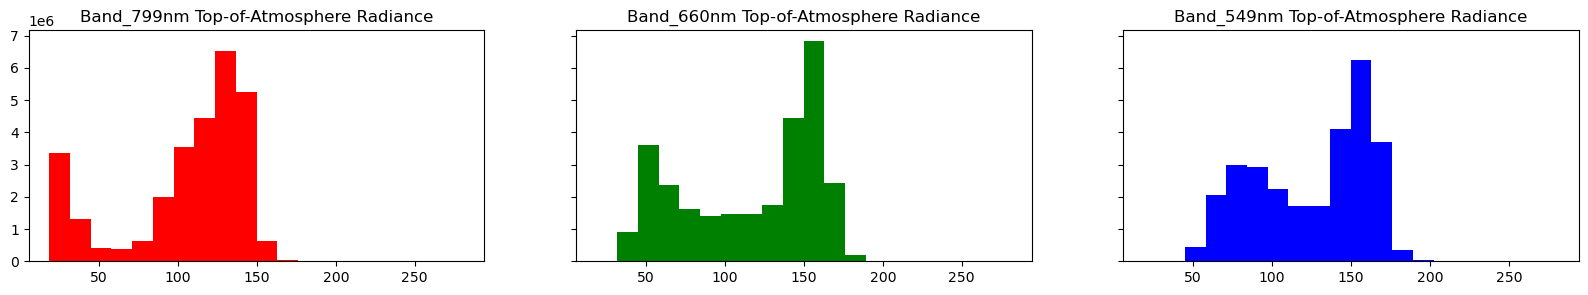

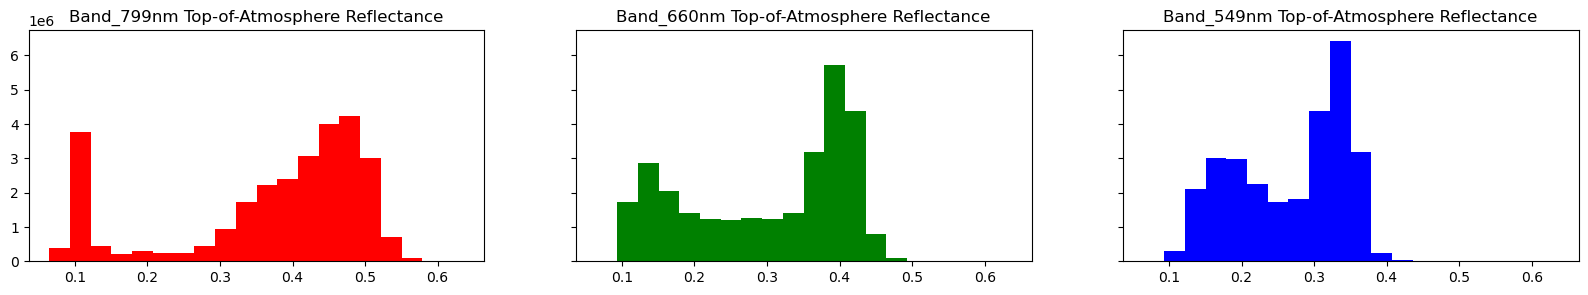

In [ ]:
# Plot cir band histograms
def plt_cir_histograms(img, title):
    red_plot_band = 22
    green_plot_band = 11
    blue_plot_band = 4

    ep.hist(
        img[[red_plot_band, green_plot_band, blue_plot_band], :, :],
        colors=["r", "g", "b"],
        title=[
            bands[red_plot_band].name + " " + title,
            bands[green_plot_band].name + " " + title,
            bands[blue_plot_band].name + " " + title,
        ],
        cols=3,
        figsize=(20, 3),
    )

plt_cir_histograms(image_toa_radiance, "Top-of-Atmosphere Radiance")
plt_cir_histograms(image_toa_reflectance, "Top-of-Atmosphere Reflectance")

### Spectral Profiles

Lastly, the spectral profile of a pixel can be shown. In this case, the profile of the image's center pixel is used.

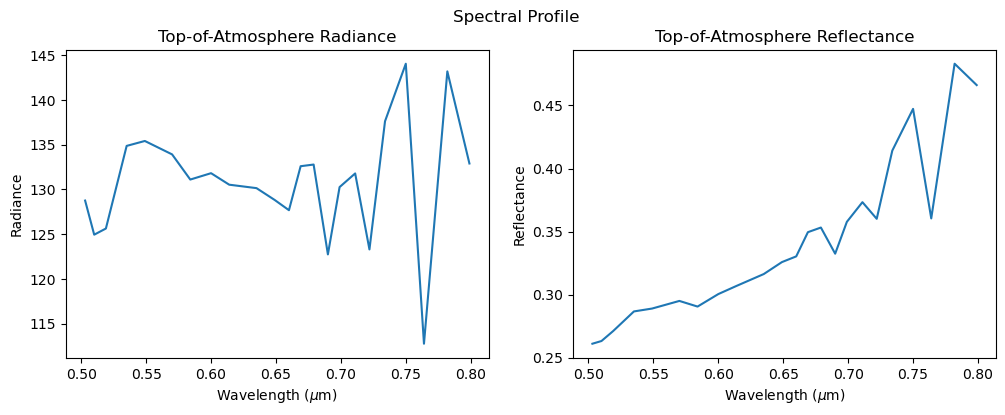

In [ ]:
# Find the center point of the image.
point = [math.floor(image_toa_radiance.shape[1] / 2), math.floor(image_toa_radiance.shape[2] / 2)]

# Get the band center wavelengths from the STAC metadata
bands_cwl = []
for i in range(len(bands)):
    bands_cwl.append(bands[i].center_wavelength)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

spectral_profile_toa_radiance = image_toa_radiance[:, point[0], point[1]]
spectral_profile_toa_reflectance = image_toa_reflectance[:, point[0], point[1]]

fig.suptitle("Spectral Profile")

ax1.plot(bands_cwl, spectral_profile_toa_radiance)
ax2.plot(bands_cwl, spectral_profile_toa_reflectance)

ax1.set_title("Top-of-Atmosphere Radiance")
ax2.set_title("Top-of-Atmosphere Reflectance")

ax1.set(xlabel=("Wavelength ($\mu$m)"), ylabel="Radiance")
ax2.set(xlabel=("Wavelength ($\mu$m)"), ylabel="Reflectance")

plt.show()

## Conclusion

This tutorial covered how to convert Wyvern Dragonette data from top-of-atmosphere radiance to top-of-atmosphere reflectance pixel units.

After this processing step the data can be converted to bottom-of-atmosphere surface reflectance pixel units using other packages, such as Py6S.